## Agregando bidireccionalidad en una RNN de analisis de sentimiento

In [49]:
from RNNs_sentimiento01 import Preprocessor, RNNode

In [50]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class BidirectionalRNN_ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(BidirectionalRNN_ANN, self).__init__()

        # Definimos la capa RNN1 (->)
        self.rnn1 = RNNode(input_size,hidden_size)
        # Definimos la capa RNN2 (<-)
        self.rnn2 = RNNode(input_size,hidden_size)

        # Definimos la estructura ANN que toma la concatenación de las salidas de las capas RNN
        
        # Añadiendo más capas ANN para el procesamiento posterior
        self.fc1 = nn.Linear(2*hidden_size, 2*hidden_size)  # Nueva capa lineal
        self.relu1 = nn.ReLU()  # Función de activación ReLU
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)  # Otra capa lineal, reduce dimensiones
        self.relu2 = nn.ReLU()  # Otra ReLU
        self.f_sent = nn.Linear(hidden_size, output_size)  # Capa final ajustada después de nuevas capas

    
    def forward(self, secuencia ):
        # Recorremos la secuencia de entrada en orden
        h1,h2 = None, None
        for x_input in secuencia:
            h1 = self.rnn1(x_input,h1)
        # Recorremos la secuencia de entrada en orden inverso
        for x_input in reversed(secuencia):
            h2 = self.rnn2(x_input,h2)
        
        # Concatenamos las salidas de las capas RNN
        h = torch.cat((h1,h2),1)

        # Pasamos la concatenación por la capa ANN
        x = self.fc1(h)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
       
        output = self.f_sent(x)
        output = torch.tanh(output)  # Manteniendo la función de activación tanh para la salida
        output = output.squeeze()  # Eliminando dimensiones extra

        return output


class SentimentBidirectional_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, Preprocessor, dropout=0.5, lr=0.001):
        super(SentimentBidirectional_RNN, self).__init__()
        self.Preprocessor = Preprocessor
        self.model = BidirectionalRNN_ANN(input_size, hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, X_train, y_train, epoch=10, batch_size=32):
        loss_list = []
        for e in range(epoch):
            total_loss = 0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.optimizer.zero_grad()
                outputs = []
                for secuencia in X_batch:
                    output = self.model(secuencia)
                    outputs.append(output)

                outputs = torch.stack(outputs).squeeze()
                loss = self.loss(outputs, torch.tensor(y_batch))
                
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                #
            loss_list.append(total_loss)
            print(f'Epoch {e+1} - Loss: {total_loss}')
        self.loss_list = loss_list

    def plot_loss(self):
        plt.plot(self.loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def evaluate(self, X_test, y_test):
        with torch.no_grad():
            total_loss = 0
            outputs = []
            for secuencia in X_test:
                output = self.model(secuencia)
                outputs.append(output)
            outputs = torch.stack(outputs).squeeze()
            total_loss = self.loss(outputs, torch.tensor(y_test)).item()
            mse = total_loss / len(y_test)
            print(f'MSE: {mse}')
        return mse

    def predict(self, texto):
        secuencia = self.Preprocessor.get_embedding_texto(texto)
        output = self.model(secuencia)
        return output.item()

        


In [51]:
# Crear el preprocesador
preprocessor_train = Preprocessor('./train_data.txt', embedding_type='glove')

Cargando GloVe...


In [52]:
# Crear el modelo
model_bidirectional = SentimentBidirectional_RNN(input_size=100,
                                                  hidden_size=300,
                                                  output_size=1,
                                                  Preprocessor=preprocessor_train)

In [53]:
# Entrenar el modelo
model_bidirectional.train(preprocessor_train.X, preprocessor_train.y, epoch=25, batch_size=32)

Epoch 1 - Loss: 5.270338146947324
Epoch 2 - Loss: 4.2198501424863935
Epoch 3 - Loss: 3.8801436107605696
Epoch 4 - Loss: 3.2594092562794685
Epoch 5 - Loss: 2.163681320846081
Epoch 6 - Loss: 1.665023073554039
Epoch 7 - Loss: 1.6691101714968681
Epoch 8 - Loss: 1.2608271706849337
Epoch 9 - Loss: 1.007008995860815
Epoch 10 - Loss: 0.7899975874461234
Epoch 11 - Loss: 0.5812674178741872
Epoch 12 - Loss: 0.48275620955973864
Epoch 13 - Loss: 0.49916941579431295
Epoch 14 - Loss: 0.291557592805475
Epoch 15 - Loss: 0.20633077900856733
Epoch 16 - Loss: 0.20602791523560882
Epoch 17 - Loss: 0.14681741106323898
Epoch 18 - Loss: 0.088183632818982
Epoch 19 - Loss: 0.06950669747311622
Epoch 20 - Loss: 0.03978548478335142
Epoch 21 - Loss: 0.022213965261471458
Epoch 22 - Loss: 0.010312491183867678
Epoch 23 - Loss: 0.007893878806498833
Epoch 24 - Loss: 0.006667118199402466
Epoch 25 - Loss: 0.005468976465635933


In [54]:
# Evaluar el modelo
preprocessor_test = Preprocessor('./test_data.txt', embedding_type='glove')
model_bidirectional.evaluate(preprocessor_test.X, preprocessor_test.y)

Cargando GloVe...
MSE: 0.04645632803440094


0.04645632803440094

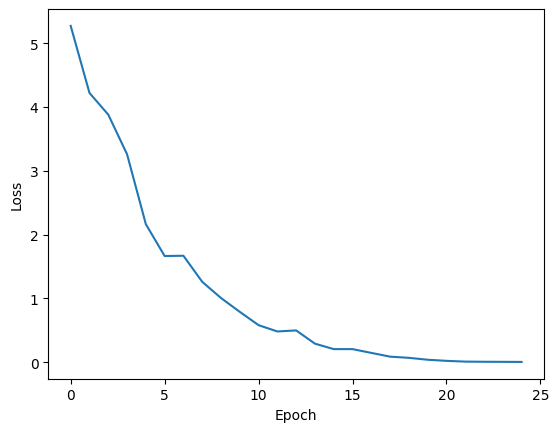

In [55]:
# Ploteamos el modelo
model_bidirectional.plot_loss()

In [57]:
# Definimos las oraciones a evaluar
sentences = [
    'Hoy siento que tengo mucha energía y entusiasmo',
    'La vida no siempre es fácil, pero hay que seguir adelante',
    'Estoy cansado de todo, nada parece tener sentido',
    'Hoy fue un día normal, sin muchas novedades',
    'Me encanta pasar tiempo con mis amigos, me hace feliz',
    'No soporto la forma en la que me tratan, me siento mal',
    'Hoy fue uno de esos días en los que todo salió bien',
    'A veces creo que no tengo claro hacia dónde voy',
    'Hoy tuve una conversación inspiradora, me siento motivado'
]

# Definimos el valor de sentimiento esperado para cada oración
target_sentiment = [0.9, 0.4, -0.7, 0.0, 0.8, -0.8, 0.9, -0.2, 0.7]

In [58]:
import plotly.graph_objects as go

def evaluate_model_bidirectional_plotly(model, sentences, target_sentiment):
    # Obtener los sentimientos predichos
    predicted_sentiment = [model.predict(sentence) for sentence in sentences]

    # Imprimir la oracion, el sentimiento esperado y el sentimiento predicho
    for i, (sentence, target, predicted) in enumerate(zip(sentences, target_sentiment, predicted_sentiment)):
        print(f"Oración {i+1}: {sentence}")
        print(f"Sentimiento esperado: {target:.2f}")
        print(f"Sentimiento predicho: {predicted:.2f}")
        print()
    
    # Crear etiquetas para el eje x
    x_labels = [f"Oración {i+1}" for i in range(len(sentences))]
    
    # Crear el gráfico de barras agrupadas
    fig = go.Figure()

    # Sentimiento esperado
    fig.add_trace(go.Bar(
        x=x_labels,
        y=target_sentiment,
        name='Sentimiento esperado',
        marker=dict(color='rgba(55, 128, 191, 0.7)'),
    ))

    # Sentimiento predicho
    fig.add_trace(go.Bar(
        x=x_labels,
        y=predicted_sentiment,
        name='Sentimiento predicho',
        marker=dict(color='rgba(219, 64, 82, 0.7)'),
    ))

    # Personalizar el diseño del gráfico
    fig.update_layout(
        title="Comparación de Sentimiento Esperado vs. Sentimiento Predicho",
        xaxis_title="Oraciones",
        yaxis_title="Sentimiento",
        barmode='group',
        xaxis_tickangle=-45,
        template="plotly_white",
    )

    # Mostrar el gráfico
    fig.show()


In [59]:
# Evaluar el modelo
evaluate_model_bidirectional_plotly(model_bidirectional, sentences, target_sentiment)

Oración 1: Hoy siento que tengo mucha energía y entusiasmo
Sentimiento esperado: 0.90
Sentimiento predicho: 0.63

Oración 2: La vida no siempre es fácil, pero hay que seguir adelante
Sentimiento esperado: 0.40
Sentimiento predicho: 0.38

Oración 3: Estoy cansado de todo, nada parece tener sentido
Sentimiento esperado: -0.70
Sentimiento predicho: 0.44

Oración 4: Hoy fue un día normal, sin muchas novedades
Sentimiento esperado: 0.00
Sentimiento predicho: 0.71

Oración 5: Me encanta pasar tiempo con mis amigos, me hace feliz
Sentimiento esperado: 0.80
Sentimiento predicho: -0.01

Oración 6: No soporto la forma en la que me tratan, me siento mal
Sentimiento esperado: -0.80
Sentimiento predicho: -0.20

Oración 7: Hoy fue uno de esos días en los que todo salió bien
Sentimiento esperado: 0.90
Sentimiento predicho: 0.20

Oración 8: A veces creo que no tengo claro hacia dónde voy
Sentimiento esperado: -0.20
Sentimiento predicho: 0.54

Oración 9: Hoy tuve una conversación inspiradora, me siento

# Evaluar un texto personalizado

In [40]:
# Guardar el modelo
torch.save(model_bidirectional, 'model_bidirectional.pth')

In [47]:
# Definimos un texto
texto = 'Hoy fue un día muy productivo, logré hacer muchas cosas'

# Predecir el sentimiento del texto
sentimiento = model_bidirectional.predict(texto)
print(f'Sentimiento del texto: {sentimiento:.2f}')

Sentimiento del texto: 0.85


In [48]:
# Definimos un texto
texto = 'No me siento bien, todo parece ir mal'

# Predecir el sentimiento del texto
sentimiento = model_bidirectional.predict(texto)
print(f'Sentimiento del texto: {sentimiento:.2f}')

Sentimiento del texto: -0.04


# Configurando el Preprocesor - Sentence Embedings

In [ ]:
import re
import pandas as pd
import numpy as np
import pickle

# Creamos una clase para preprocesar los datos
class Preprocessor:    
    def __init__(self, path: str, embedding_type='glove') -> None:
        # Atributo (str) path de la clase
        self.path = path
        # Leemos el archivo
        self.text = self.read_path(self.path)
        # Creamos un diccionario de parrafos y sentimientos
        self.data = self.create_data(self.text)
        #print(self.data)
        # Creamos un dataframe
        self.df = self.create_df(self.data)
        # Creamos un df de palabras y sentimientos
        self.df_words = self.create_df_words(self.df)
        
        # Cargar modelo de embeddings
        self.embedding_type = embedding_type
        if embedding_type == 'glove':
            print("Cargando GloVe...")
            # extraemos el archivo pickle
            self.embedding_model = pickle.load(open("glove_model.pkl", 'rb'))
            self.embedding_dim = 100
        elif embedding_type == 'word2vec':
            print("Cargando Word2Vec...")
            self.embedding_model = pickle.load(open("word2vec_model.pkl", 'rb'))
            self.embedding_dim = 300
        else:
            raise ValueError("Tipo de embedding no soportado. Usa 'glove' o 'word2vec'.")

        # Creamos una lista de tensores de secuencias y sus targets
        self.X, self.y = self.create_X_y_words(self.df_words)
    
    def get_embedding_texto(self, texto: str) -> list:
        ''' Método que obtiene los embeddings de un texto '''
        texto = re.findall(r'\w+', texto.lower())
        embeddings = [self.embedding_model[word] for word in texto if word in self.embedding_model]
        # Convertimos la lista de embeddings a un tensor
        if embeddings:
                # convertimos la lista de embeddings a un tensor
            embeddings = [torch.tensor(embedding) for embedding in embeddings]
        else:
            embeddings = np.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas

        return embeddings
    
    def create_X_y_text(self, df: str) -> torch.Tensor:
        X = []
        y = []
        for parrafo,sentimiento in zip(df['parrafos'],df['sentimientos']):
            embeddings = [self.embedding_model[word] for word in parrafo if word in self.embedding_model]
            if embeddings:
                # Calculamos el promedio de los embeddings
                paragraph_embedding = torch.tensor(embeddings).mean(dim=0)
            else:
                paragraph_embedding = np.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas
            X.append(paragraph_embedding)
            # Convertimos el sentimiento a tensor
            sentimiento = torch.tensor(sentimiento)
            y.append(sentimiento)
        return X,y
    
    def create_X_y_words(self, df: pd.DataFrame) -> list:
        ''' Método que crea una lista de embeddings de secuencias '''
        X = []
        y = []
        for parrafo,sentimiento in zip(df['parrafos'],df['sentimientos']):
            embeddings = [self.embedding_model[word] for word in parrafo if word in self.embedding_model]
            if embeddings:
                # convertimos la lista de embeddings a un tensor
                paragraph_embedding = [torch.tensor(embedding) for embedding in embeddings]
            else:
                paragraph_embedding = np.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas
            X.append(paragraph_embedding)
            # Convertimos el sentimiento a tensor
            sentimiento = torch.tensor(sentimiento)
            y.append(sentimiento)
        
        return X, y
    
    def create_df_words(self, df: pd.DataFrame) -> pd.DataFrame:
        ''' Método que crea un dataframe de palabras y sentimientos '''
        df_words = df.copy()
        df_words['parrafos'] = df['parrafos'].apply(lambda x: re.findall(r'\w+', x.lower()))
        return df_words
    
    def create_df(self, data: dict) -> pd.DataFrame:
        ''' Método que crea un dataframe a partir de un diccionario de parrafos y sentimientos '''
        df = pd.DataFrame(data)
        return df
    
    def create_data(self, text: str) -> dict:
        ''' Método que crea un diccionario de parrafos y sentimientos '''
        parrafos = re.findall(r'Parrafo_\d+:\n(.*?)\nsentimiento_\d+:\n', text, re.DOTALL)
        sentimientos = re.findall(r'sentimiento_\d+:\n(.*?)(?:\n|$)', text, re.DOTALL)
        # Convertimos los sentimientos a float
        sentimientos = [float(sentimiento) for sentimiento in sentimientos]
        data = {'parrafos': parrafos, 'sentimientos': sentimientos }
        return data
    
    def read_path(self, path: str) -> str:
        ''' Método que lee un archivo de texto y retorna el texto '''
        with open(path, 'r', encoding='utf-8') as file:
            text = file.read()
        return text